In [1]:
import torch
print(torch.__version__)

2.1.2


In [2]:
!pip install git+https://github.com/facebookresearch/detectron2.git

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-z7qmhxy2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-z7qmhxy2
  Resolved https://github.com/facebookresearch/detectron2.git to commit 3ff5dd1cff4417af07097064813c9f28d7461d3c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7

In [3]:
import pandas as pd
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
#from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional


# torch
import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob
import json
# numba
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset,RotatedCOCOEvaluator

setup_logger()

<_Logger detectron2 (DEBUG)>

In [4]:
#f = open('/kaggle/input/papers-images/train/train/samples.json',)
f = open("/kaggle/input/tables-data/train.json")
thing_classes  = []
thing_classes_id = {}
data_annotations=[]
data = json.load(f)
#----Images----
data_images=data['images']
#---annotations-
for i in data['annotations']:
    annot_obj ={"id": i['id'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+hieght
         }
    data_annotations.append(annot_obj)
#---categories-
for i in data['categories']:
    thing_classes.append(i['name'])
    thing_classes_id[i['name']]=i['id']
f.close()
print("thing_classes=",thing_classes)
print("thing_classes_id=",thing_classes_id)


thing_classes= ['HIC_table', 'US_table']
thing_classes_id= {'HIC_table': 0, 'US_table': 1}


In [5]:
thing_classes= ['HIC_table', 'US_table', 'None', 'None', 'None', 'None']

In [6]:
train_meta = pd.DataFrame(data_images)
train_meta = train_meta[['id', 'file_name', 'width', 'height']]
train_meta = train_meta.rename(columns={"id":"image_id"})
print("train_meta size=",len(train_meta))
train_meta.head(3)

train_meta size= 159


,image_id,file_name,width,height
0,1,doc_img_us_37.jpg,2526,1785
1,2,doc_img_us_39.jpg,2526,1785
2,3,doc_img_us_67.jpg,2526,1785


In [7]:
train_df = pd.DataFrame(data_annotations)
print("train_df size=",len(train_df))
train_df.head(3)

train_df size= 163


,id,image_id,category_id,x_min,y_min,x_max,y_max
0,1,1,1,28.803922,333.794118,1542.529412,1333.794118
1,2,2,1,30.686275,339.598039,1544.411765,1339.598039
2,3,3,1,32.607843,339.558824,1546.333333,1339.558824


In [8]:
#imgdir="/kaggle/input/papers-images/train/train"
imgdir = "/kaggle/input/tables-data"

debug=False
split_mode="valid20" # all_train Or  valid20
image_Width=640
image_Height=640

num_folds=5
Selected_fold=1 #1,2,3,4,5

In [9]:
def get_PL_data_dicts(
    imgdir: Path,
    _train_df: pd.DataFrame,
    _train_meta: pd.DataFrame,
    use_cache: bool = True,
    target_indices: Optional[np.ndarray] = None,
    debug: bool = False,
    data_type:str="train"

):
    if debug:
            train_meta = train_meta.iloc[:100]  # For debug...
    dataset_dicts = []
    for index, train_meta_row in tqdm(_train_meta.iterrows(), total=len(_train_meta)):
                    record = {}
                    image_id,file_name, width,height = train_meta_row.values
                    filename = str(f'{imgdir}/{file_name}')
                    record["file_name"] = filename
                    record["image_id"] = image_id
                    record["width"] = width
                    record["height"] = height
                    objs = []
                    for index2, row in _train_df.query("image_id == @image_id").iterrows():
                        class_id = row["category_id"]
                        bbox_resized = [
                            float(row["x_min"]),
                            float(row["y_min"]),
                            float(row["x_max"]),
                            float(row["y_max"]),
                        ]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    record["annotations"] = objs
                    dataset_dicts.append(record)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts



In [10]:
Data_Resister_training="PL_data_train";
Data_Resister_valid="PL_data_valid";

if split_mode == "all_train":
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)


    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)


elif split_mode == "valid20":

    n_dataset = len(train_meta)
    n_train = int(n_dataset * 0.95)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(12)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=train_inds,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)


    DatasetCatalog.register(
        Data_Resister_valid,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=valid_inds,
            debug=debug,
            data_type="val"
            ),
        )
    MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)

    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

    dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
    metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)

else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

n_dataset 159 n_train 151


  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

In [11]:
print("dicts training size=",len(dataset_dicts_train),"################  dicts valid size=",len(dataset_dicts_valid))

dicts training size= 151 ################  dicts valid size= 8


In [12]:
from detectron2.engine import DefaultTrainer

In [13]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)

if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = (Data_Resister_valid,)
    cfg.TEST.EVAL_PERIOD = 1000

cfg.DATALOADER.NUM_WORKERS = 0
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.MODEL.WEIGHTS="/kaggle/input/layout-parser-weights/Weights/faster_rcnn_R_50_FPN_3x/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025

cfg.SOLVER.WARMUP_ITERS = 10
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (500, 1000) # must be less than  MAX_ITER
cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
#trainer = AugTrainer(cfg)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/10 15:53:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/159 [00:00<?, ?it/s]

[02/10 15:53:25 d2.data.build]: Removed 0 images with no usable annotations. 151 images left.
[02/10 15:53:25 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| HIC_table  | 76           |  US_table  | 79           |    None    | 0            |
|    None    | 0            |    None    | 0            |    None    | 0            |
|            |              |            |              |            |              |
|   total    | 155          |            |              |            |              |
[02/10 15:53:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/10 15:53:25 d2.data.build]: Using training sampler TrainingSampler
[02/10 15:53:25 d2.data.c

2024-02-10 15:53:56.441515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 15:53:56.441626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 15:53:56.557337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[02/10 15:54:28 d2.utils.events]:  eta: 0:37:52  iter: 39  total_loss: 0.6834  loss_cls: 0.07243  loss_box_reg: 0.5375  loss_rpn_cls: 0.001868  loss_rpn_loc: 0.005884    time: 1.1558  last_time: 1.1608  data_time: 0.7267  last_data_time: 0.7111   lr: 0.0025  max_mem: 4230M
[02/10 15:54:50 d2.utils.events]:  eta: 0:37:14  iter: 59  total_loss: 0.6018  loss_cls: 0.1301  loss_box_reg: 0.4877  loss_rpn_cls: 0.003623  loss_rpn_loc: 0.005056    time: 1.1461  last_time: 1.1514  data_time: 0.7053  last_data_time: 0.7392   lr: 0.0025  max_mem: 4230M
[02/10 15:55:13 d2.utils.events]:  eta: 0:36:36  iter: 79  total_loss: 0.5412  loss_cls: 0.08911  loss_box_reg: 0.4157  loss_rpn_cls: 0.004692  loss_rpn_loc: 0.004041    time: 1.1402  last_time: 1.1208  data_time: 0.6997  last_data_time: 0.7085   lr: 0.0025  max_mem: 4230M
[02/10 15:55:35 d2.utils.events]:  eta: 0:36:11  iter: 99  total_loss: 0.4516  loss_cls: 0.04111  loss_box_reg: 0.3842  loss_rpn_cls: 0.005198  loss_rpn_loc: 0.004272    time: 1.1

  0%|          | 0/159 [00:00<?, ?it/s]

[02/10 16:12:42 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| HIC_table  | 3            |  US_table  | 5            |    None    | 0            |
|    None    | 0            |    None    | 0            |    None    | 0            |
|            |              |            |              |            |              |
|   total    | 8            |            |              |            |              |
[02/10 16:12:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 16:12:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/10 16:12:42 d2.data.common]: Serializing 8 elements to byte tensors and concatenating them all ...
[0

  0%|          | 0/159 [00:00<?, ?it/s]

[02/10 16:31:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 16:31:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/10 16:31:43 d2.data.common]: Serializing 8 elements to byte tensors and concatenating them all ...
[02/10 16:31:43 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [02/10 16:31:43 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


In [14]:
evaluator = COCOEvaluator(Data_Resister_training, cfg, False, output_dir="./output/")
evaluatorIoU = RotatedCOCOEvaluator(Data_Resister_training, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
val_loader = build_detection_test_loader(cfg, Data_Resister_training)
inference_on_dataset(trainer.model, val_loader, evaluatorIoU)

WARNING [02/10 16:31:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/10 16:31:43 d2.evaluation.coco_evaluation]: Trying to convert 'PL_data_train' to COCO format ...
[02/10 16:31:43 d2.data.datasets.coco]: Converting annotations of dataset 'PL_data_train' to COCO format ...)


  0%|          | 0/159 [00:00<?, ?it/s]

[02/10 16:31:44 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/10 16:31:44 d2.data.datasets.coco]: Conversion finished, #images: 151, #annotations: 155
[02/10 16:31:44 d2.data.datasets.coco]: Caching COCO format annotations at './output/PL_data_train_coco_format.json' ...
WARNING [02/10 16:31:44 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


  0%|          | 0/159 [00:00<?, ?it/s]

[02/10 16:31:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 16:31:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/10 16:31:44 d2.data.common]: Serializing 151 elements to byte tensors and concatenating them all ...
[02/10 16:31:44 d2.data.common]: Serialized dataset takes 0.05 MiB
[02/10 16:31:44 d2.evaluation.evaluator]: Start inference on 151 batches
[02/10 16:31:47 d2.evaluation.evaluator]: Inference done 11/151. Dataloading: 0.1459 s/iter. Inference: 0.0670 s/iter. Eval: 0.0003 s/iter. Total: 0.2131 s/iter. ETA=0:00:29
[02/10 16:31:52 d2.evaluation.evaluator]: Inference done 32/151. Dataloading: 0.1683 s/iter. Inference: 0.0672 s/iter. Eval: 0.0003 s/iter. Total: 0.2358 s/iter. ETA=0:00:28
[02/10 16:31:57 d2.evaluation.evaluator]: Inference done 53/151. Dataloading: 0.1708 s/iter. Inference: 0.0673

OrderedDict([('bbox',
              {'AP': 92.206600660066,
               'AP50': 97.02970297029702,
               'AP75': 97.02970297029702,
               'APs': nan,
               'APm': nan,
               'APl': 92.206600660066,
               'AP-HIC_table': 100.0,
               'AP-US_table': 84.413201320132,
               'AP-None': nan})])

In [15]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T

,0,1,2,3,4,5,6,7,8,9
data_time,0.732125,0.721541,0.703966,0.695421,0.695319,0.687220,0.703601,0.703116,0.706452,0.703745
eta_seconds,2298.206663,2272.703289,2234.280439,2196.087760,2171.433874,2138.730571,2115.978118,2092.947218,2071.173838,2049.670110
fast_rcnn/cls_accuracy,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
fast_rcnn/false_negative,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fast_rcnn/fg_cls_accuracy,0.625000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
iteration,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000,179.000000,199.000000
loss_box_reg,0.640409,0.537535,0.487710,0.415724,0.384226,0.385946,0.340494,0.364170,0.324199,0.350303
loss_cls,0.289616,0.072435,0.130125,0.089114,0.041115,0.055055,0.056613,0.061828,0.029247,0.048165
loss_rpn_cls,0.012329,0.001868,0.003623,0.004692,0.005198,0.003121,0.001984,0.003948,0.002706,0.001760
loss_rpn_loc,0.007229,0.005884,0.005056,0.004041,0.004272,0.003708,0.003176,0.005084,0.003267,0.003408


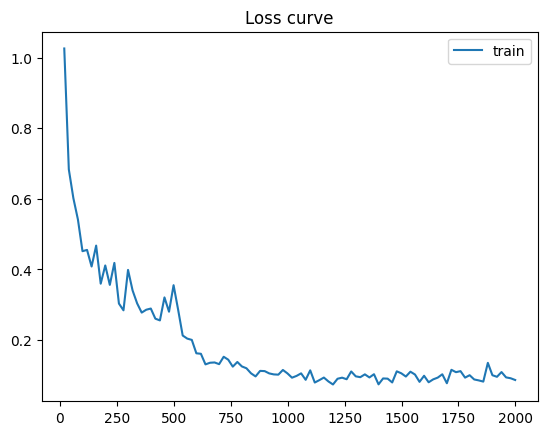

In [16]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

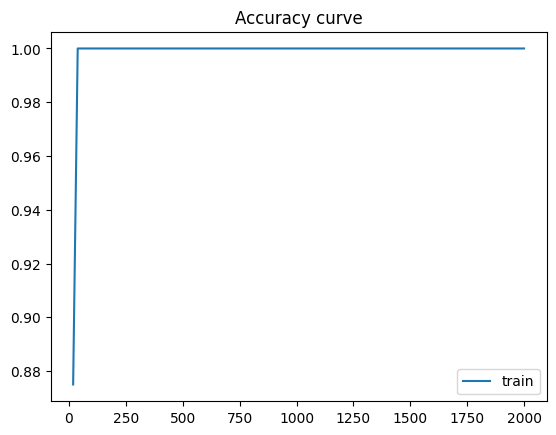

In [17]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

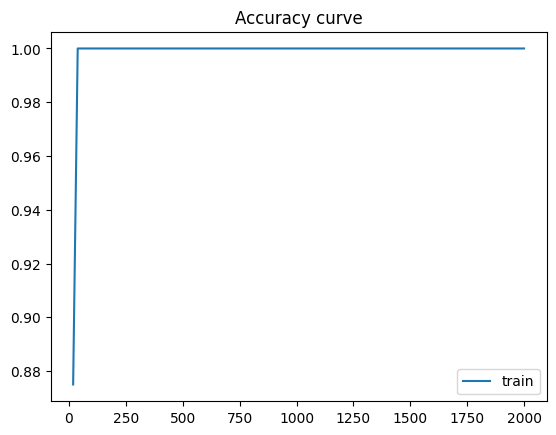

In [18]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

In [19]:
!pip install -U layoutparser 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 77.2 MB/s eta 0:00:00


In [20]:
import layoutparser as lp

In [21]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 '/kaggle/working/output/model_final.pth',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.95],
                                 label_map={0:"HIC_table",1: "US_table", 2: "None", 3: "None", 4:"None", 5:"None"})
#######################################################
#image = cv2.imread('/kaggle/input/compressed-data/doc_smaller_26.jpg')
#plt.imshow(image)
color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'yellow',
    'figure': 'pink',
}


config.yml?dl=1: 8.19kB [00:01, 7.05kB/s]


[02/10 16:32:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/model_final.pth ...


In [22]:
import cv2
image = cv2.imread("/kaggle/input/tables-data/doc_img_us_29.jpg")
image = image[..., ::-1]

In [23]:
image.shape

(1785, 2526, 3)

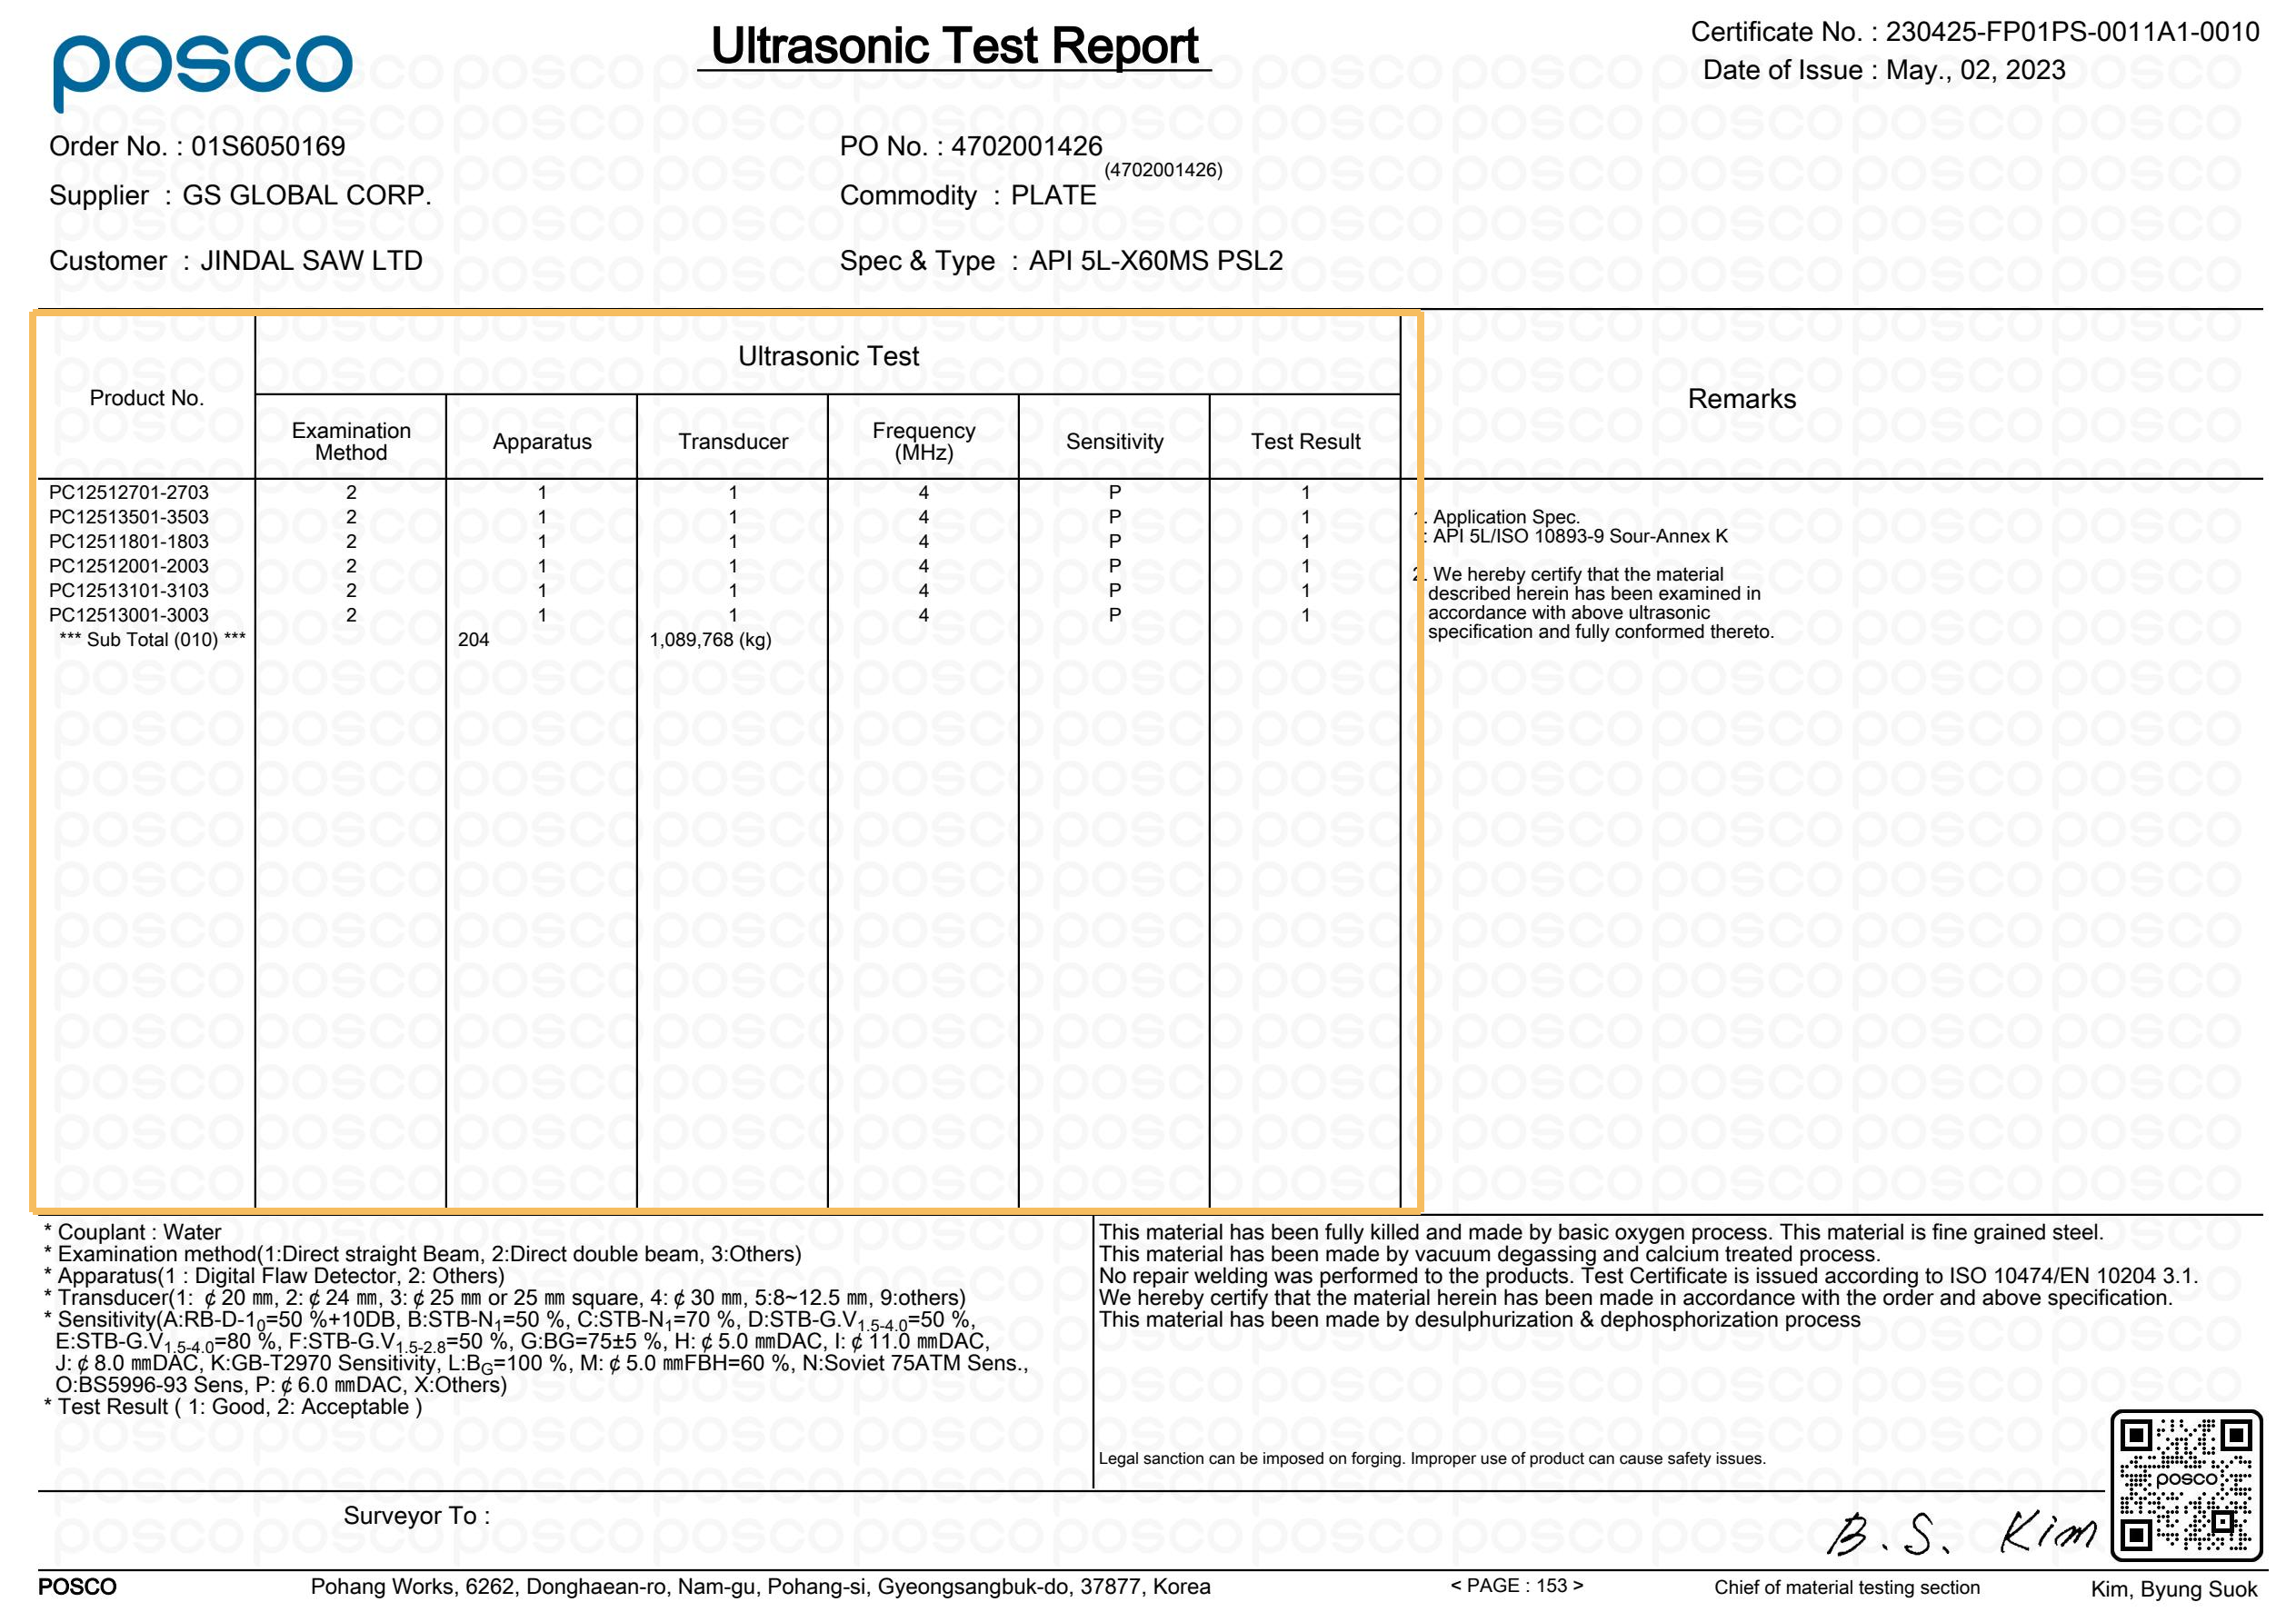

In [24]:
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout)

In [25]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=36.1791877746582, y_1=343.7441711425781, x_2=1562.50146484375, y_2=1333.3131103515625), text=None, id=None, type=US_table, parent=None, next=None, score=0.9907147884368896)], page_data={})